In [1]:
# Import tensorflow for the CNN and limit the memory usage
import tensorflow as tf
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="1" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

2021-10-05 16:21:14.875866: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-05 16:21:15.008170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:5b:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2021-10-05 16:21:15.008979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:9e:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2021-10-05 16:21:15.009322: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-05 16:21:15.012365: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10

In [2]:
# Load necessary libraries
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound
from botorch.models.transforms.outcome import Standardize

import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Parameters setup
device = "cpu"  # for now, set device to CPU as the number of samples are small.
dtype = torch.double
NOISE_SE = 0.0
niter = 50
nrep = 1
option_standardize = True

In [4]:
# Function that loads the saved weights in CNN.

# input:
# path: hdf5 file that saves the weights of a VGG16 network.

# output:
# model: Keras model with VGG16 architecture and the loaded weights.
from keras import applications
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

def loadCNNmodel(path):
    model = applications.VGG16(weights=None, include_top=False, input_shape=(128, 128, 3))
    print('Model loaded')
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.0))
    top_model.add(Dense(1,activation=None))
    new_model = Sequential()

    for l in model.layers:
        new_model.add(l)

    new_model.add(top_model)
    new_model.load_weights(path)
    print('CNN model loaded with weights.')
    return new_model

Using TensorFlow backend.


In [5]:
# model using the whole FOV
model_path = '/home/chenyu/Desktop/CNNmeasurement/CoarseCNNtraining/VGG16/OptimalPar_newData/Test6_Normalize_HighCs_emitxdefocus/Attempt_10_emit+defocus_Adam/Final_model_2.h5'
# refine model using 30 mrad aperture
model_path_finetune = '/home/chenyu/Desktop/CNNmeasurement/CoarseCNNtraining/VGG16/OptimalPar_newData/Test12_Normalize_Cs_3fold_C5_negC1_WhiteNoise_Aperture/Attempt_01_emit+defocus_dropout_0.1_30mrad/Final_model.h5'

model = loadCNNmodel(model_path)
model_finetune = loadCNNmodel(model_path_finetune)

2021-10-05 16:21:16.159941: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-10-05 16:21:16.186527: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2200000000 Hz
2021-10-05 16:21:16.190616: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f02d0000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-05 16:21:16.190656: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-05 16:21:16.434592: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555d54dc8fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-10-05 16:21:16.434640: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 4000, Compute Capability 7.5
2021-10-05 16:21:16.434652: I tensorflow

Model loaded
CNN model loaded with weights.
Model loaded
CNN model loaded with weights.


In [6]:
def scale_range(input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

In [7]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [32]:
# the function to get the output from GPT
# input:
# x: coordinate in the parameter space to be observed, 1-by-6 numpy array with each number between [0,1].
# model: Keras model that saves the CNN model to quantify the beam quality from GPT output.

# output:
# y: single number from CNN output, higher stands for better beam quality.
import sys
sys.path.insert(1, '/home/chenyu/Desktop/git/STEMalign/GPT_misalignment/')
from uscope import sim

def get_GPT_output(x, model, aperture):
    x_list = []
    x_low = np.asarray([1000, -40, 387000, -685000, -3.7515e6, 119000, 640000])
    x_high = np.asarray([2800, 40, 393000, -622500, -3.7495e6, 120300, 651000])
    xlim, ylim, shadow = sim(             
         S1CV  = (x[6] - 0.5) * 2e-7,
         S1CH  = (x[7] - 0.5) * 2e-7,
         S2CV  = (x[8] - 0.5) * 2e-7,
         S2CH  = (x[9] - 0.5) * 2e-7,
         S3CV  = 0.0,
         S3CH  = 0.0,
         H1CV  = 0.0,
         H1CH  = 0.0,
         S4CV  = 0.0,
         S4CH  = 0.0,
         S5CV  = 0.0,
         S5CH  = 0.0,
         H2CV  = 0.0,
         H2CH  = 0.0,
         S6CV  = 0.0,
         S6CH  = 0.0,
         S7CV  = 0.0,
         S7CH  = 0.0,
         ObjCH = 0.0,
         ObjCV = 0.0,
         alpha = 1.0e-4*5,
         S1 = 2.5e5,
         S2 = 2.5e5,
         H1 = x[0] * (x_high[0] - x_low[0]) + x_low[0],
         H2 = x[0] * (x_high[0] - x_low[0]) + x_low[0] + x[1] * (x_high[1] - x_low[1]) + x_low[1],
         S3 = x[4]* (x_high[5] - x_low[5]) + x_low[5],  # 119931.5,
         S4 = x[5]* (x_high[6] - x_low[6]) + x_low[6],  # 648691.415,
         S6 = x[2]* (x_high[2] - x_low[2]) + x_low[2],  # 390000,
         S7 = x[3]* (x_high[3] - x_low[3]) + x_low[3],  # -654100.0
         Obj = -3.7505e6,
         erL = 1e-7,
    )
    frame = scale_range(shadow, 0, 1)
    if aperture:
        frame = frame * aperture_generator(128, 40, 30)
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_list.append(img_stack)
    x_list = np.concatenate([arr[np.newaxis] for arr in x_list])
    prediction = model.predict(x_list, batch_size = 1)
    # print(prediction)
    return shadow, 1 - prediction[0][0]

0.8216721266508102


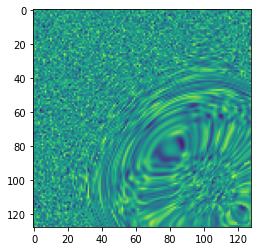

In [34]:
# test with arbitrary input x
# x = np.array([0,0,0,0,0,0])
x = np.array([ 0.2768, 0.5056, 0.5, 0.4944, 0.7165, 0.7901, 1,1,1,1])
# x = np.array([0.5449, 0.1241, 0.7564, 0.5801, 0.4578, 0.9086])
ronch, output = get_GPT_output(x, model, 0)
print(output)
plt.imshow(ronch)

In [35]:
# Function that generate n random data point with noise.

# input:
# n: number of datapoints to gerate
def generate_initial_data(n, model, aperture):
    # generate training data
    train_x = torch.rand(n, 10, device=device, dtype=dtype)
    output_y = [get_GPT_output(np.array(train_x[i,:]), model, aperture)[1] for i in range(n)]
    train_y = torch.tensor(output_y).unsqueeze(-1)
    train_y = train_y + NOISE_SE * torch.randn_like(train_y) if NOISE_SE else train_y
    best_observed_value = train_x.max().item()
    return train_x, train_y

In [36]:
# initial optimization without applying aperture
best_seen_rep = []
best_par_rep = []
best_ronchigram_rep = []
best_seen_ronchigram = np.zeros([128, 128])

if option_standardize:
    outcome_transformer = Standardize( m = 1,
    batch_shape = torch.Size([]),
    min_stdv = 1e-08)

for irep in range(nrep):
    
    train_X, train_Y = generate_initial_data(n = 10, model = model, aperture = 0)
    
    if option_standardize:
        gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
    else:
        gp = SingleTaskGP(train_X, train_Y)
        
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    bounds = torch.stack([torch.zeros(10, device = device), torch.ones(10, device = device)])
    best_observed_value = []
    
    for iteration in range(niter):

        fit_gpytorch_model(mll)

        UCB = UpperConfidenceBound(gp, beta = 2)    
        candidate, acq_value = optimize_acqf(
            UCB, bounds=bounds, q = 1, num_restarts=5, raw_samples=20,
        )
        new_x = candidate.detach()
        print(new_x)
        
        result = get_GPT_output(np.array(new_x[0]), model, 0)
        new_y = torch.tensor(result[1]).unsqueeze(-1).unsqueeze(-1)
        new_y = new_y + NOISE_SE * torch.randn_like(new_y)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
        if not best_observed_value:
            best_par = np.array(new_x[0])
            best_value = np.array(new_y[0][0])
            best_seen_ronchigram = result[0]
        elif result[1] > best_value:
            best_par = np.array(new_x[0])
            best_value = result[1]
            best_seen_ronchigram = result[0]
        best_observed_value.append(best_value)

        # update GP model using dataset with new datapoint
        if option_standardize:
            gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
        else:
            gp = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

        print(iteration, best_value)
        
    best_seen_rep.append(np.array(best_observed_value))
    best_par_rep.append(best_par)
    best_ronchigram_rep.append(best_seen_ronchigram)
    
# np.save('Initial_optimization_std_50iter_50reps_value.npy', np.array(best_seen_rep))
# np.save('Initial_optimization_std_50iter_50reps_ronchigrams.npy', np.array(best_ronchigram_rep))
# np.save('Initial_optimization_std_50iter_50reps_parameters.npy', np.array(best_par_rep))

tensor([[0.5235, 0.3869, 0.4010, 0.2723, 0.8933, 0.7669, 0.1066, 0.5804, 0.1317,
         0.9181]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 0.6442286968231201
tensor([[0.5730, 0.4071, 0.4256, 0.2733, 0.8003, 0.6328, 0.1573, 0.5646, 0.1285,
         0.8407]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 0.8653715550899506
tensor([[0.5441, 0.4414, 0.4005, 0.2561, 0.7459, 0.6254, 0.1111, 0.5979, 0.1460,
         0.9099]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2 0.8653715550899506
tensor([[0.6297, 0.4555, 0.4285, 0.2893, 0.8248, 0.6356, 0.1147, 0.5362, 0.0619,
         0.8872]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3 0.8653715550899506
tensor([[0.5770, 0.4697, 0.4355, 0.2666, 0.7824, 0.6464, 0.1959, 0.4750, 0.1573,
         0.8818]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4 0.8657426834106445
tensor([[0.6408, 0.4412, 0.5077, 0.2984, 0.7576, 0.6518, 0.1647, 0.5693, 0.1683,
         0.8629]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5 0.8657426834106445
tensor([[0.5907, 0.3945, 0.3596, 0.2860, 0.7826, 0.6439, 0.1131, 0.4375, 0.1457,
         0.8301]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


6 0.8657426834106445
tensor([[0.4835, 0.4420, 0.4649, 0.2737, 0.8136, 0.6397, 0.1948, 0.5041, 0.0485,
         0.8783]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7 0.8657426834106445
tensor([[0.5194, 0.4794, 0.4080, 0.2933, 0.8959, 0.6333, 0.2150, 0.5495, 0.1552,
         0.8962]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


8 0.8657426834106445
tensor([[0.5725, 0.4510, 0.4103, 0.1741, 0.8195, 0.6447, 0.2303, 0.5451, 0.0613,
         0.8631]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


9 0.8657426834106445
tensor([[0.5289, 0.4862, 0.4051, 0.3309, 0.7735, 0.6485, 0.2065, 0.5504, 0.0753,
         0.8419]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10 0.8657426834106445
tensor([[0.5047, 0.4850, 0.4627, 0.2453, 0.8456, 0.6417, 0.1114, 0.5052, 0.1440,
         0.8294]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


11 0.8657426834106445
tensor([[0.5476, 0.3522, 0.4415, 0.2773, 0.8261, 0.6397, 0.1965, 0.5015, 0.1183,
         0.9488]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


12 0.8657426834106445
tensor([[0.5270, 0.4358, 0.4026, 0.2622, 0.8163, 0.6425, 0.1792, 0.5292, 0.0982,
         0.8724]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


13 0.8657426834106445
tensor([[0.5418, 0.4195, 0.4518, 0.3011, 0.8318, 0.6254, 0.2007, 0.4679, 0.1297,
         0.8622]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


14 0.8657426834106445
tensor([[0.5729, 0.4739, 0.4431, 0.2592, 0.8195, 0.6456, 0.2210, 0.5842, 0.0632,
         0.8575]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


15 0.8657426834106445
tensor([[0.5099, 0.4590, 0.4356, 0.2646, 0.7869, 0.6516, 0.1576, 0.5270, 0.1082,
         0.8962]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


16 0.8657426834106445
tensor([[0.5991, 0.4498, 0.3802, 0.2639, 0.8533, 0.6433, 0.1771, 0.5513, 0.1414,
         0.8466]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


17 0.8657426834106445
tensor([[0.5028, 0.4084, 0.4369, 0.2783, 0.8362, 0.6359, 0.1316, 0.5890, 0.0286,
         0.8536]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


18 0.8657426834106445
tensor([[0.5442, 0.4292, 0.4393, 0.2568, 0.7560, 0.6364, 0.1508, 0.5199, 0.0280,
         0.8569]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 0.8657426834106445
tensor([[0.4759, 0.4145, 0.4389, 0.2699, 0.8155, 0.6412, 0.1924, 0.5915, 0.1428,
         0.8591]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


20 0.8683018982410431
tensor([[0.4841, 0.4133, 0.4337, 0.2892, 0.8279, 0.6417, 0.1507, 0.5923, 0.1508,
         0.8672]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


21 0.8683018982410431
tensor([[0.4605, 0.4067, 0.4299, 0.2585, 0.7949, 0.6433, 0.2217, 0.5620, 0.1591,
         0.8578]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


22 0.8737161755561829
tensor([[0.4073, 0.3753, 0.4287, 0.2601, 0.7999, 0.6463, 0.2530, 0.5617, 0.1418,
         0.8478]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


23 0.8775728270411491
tensor([[0.3099, 0.3905, 0.4248, 0.2534, 0.7923, 0.6334, 0.2832, 0.5833, 0.1415,
         0.8499]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


24 0.8794433102011681
tensor([[0.3037, 0.4243, 0.4239, 0.2448, 0.7618, 0.6423, 0.3390, 0.5248, 0.2211,
         0.8545]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


25 0.8971917480230331
tensor([[0.2786, 0.4200, 0.4165, 0.2268, 0.7173, 0.6415, 0.4331, 0.5183, 0.3369,
         0.8394]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


26 0.8971917480230331
tensor([[0.1939, 0.4703, 0.4304, 0.2459, 0.7867, 0.6482, 0.3264, 0.4761, 0.1655,
         0.8654]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


27 0.8971917480230331
tensor([[0.3820, 0.4482, 0.4562, 0.2433, 0.7580, 0.6258, 0.3606, 0.5633, 0.1928,
         0.8533]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


28 0.8971917480230331
tensor([[0.3723, 0.4299, 0.3705, 0.2461, 0.7527, 0.6254, 0.3182, 0.5351, 0.2232,
         0.8500]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


29 0.8971917480230331
tensor([[0.3684, 0.4210, 0.4185, 0.2791, 0.7813, 0.6429, 0.3703, 0.5846, 0.2184,
         0.8722]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


30 0.9057170897722244
tensor([[0.3683, 0.4260, 0.4210, 0.2717, 0.8145, 0.6449, 0.3778, 0.5758, 0.2160,
         0.8160]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


31 0.9057170897722244
tensor([[0.3630, 0.4170, 0.4265, 0.2329, 0.7950, 0.6382, 0.3577, 0.5895, 0.2438,
         0.9003]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


32 0.9057170897722244
tensor([[0.3550, 0.3880, 0.4164, 0.3183, 0.6894, 0.6354, 0.4018, 0.5735, 0.1841,
         0.8490]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


33 0.9057170897722244
tensor([[0.3708, 0.4808, 0.4095, 0.2852, 0.7735, 0.6324, 0.3160, 0.5847, 0.2440,
         0.8442]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


34 0.9057170897722244
tensor([[0.3786, 0.4915, 0.3776, 0.2706, 0.7721, 0.6434, 0.3743, 0.5768, 0.1849,
         0.8482]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


35 0.9057170897722244
tensor([[0.3723, 0.4692, 0.4096, 0.2921, 0.7900, 0.6358, 0.3877, 0.5251, 0.2150,
         0.8543]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


36 0.9057170897722244
tensor([[0.3688, 0.4835, 0.4435, 0.2781, 0.7668, 0.6518, 0.3439, 0.5550, 0.2300,
         0.8486]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


37 0.9057170897722244
tensor([[0.3624, 0.4585, 0.3772, 0.2884, 0.7919, 0.6305, 0.3909, 0.6015, 0.1910,
         0.8518]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


38 0.9057170897722244
tensor([[0.3641, 0.4253, 0.3543, 0.2885, 0.7854, 0.6427, 0.3713, 0.5777, 0.2320,
         0.8516]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


39 0.9057170897722244
tensor([[0.3541, 0.4599, 0.4278, 0.2839, 0.7862, 0.6348, 0.4009, 0.5925, 0.1779,
         0.8511]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


40 0.9057170897722244
tensor([[0.3645, 0.4364, 0.3970, 0.2728, 0.7802, 0.6396, 0.3995, 0.5486, 0.1720,
         0.8518]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


41 0.9057170897722244
tensor([[0.3500, 0.4285, 0.4227, 0.2850, 0.7843, 0.6335, 0.3654, 0.5682, 0.2239,
         0.8516]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


42 0.908621720969677
tensor([[0.3467, 0.4534, 0.4059, 0.2897, 0.7799, 0.6352, 0.3436, 0.5658, 0.1914,
         0.8566]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


43 0.908621720969677
tensor([[0.3807, 0.4223, 0.4166, 0.2750, 0.7863, 0.6366, 0.4232, 0.6010, 0.2448,
         0.8499]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


44 0.908621720969677
tensor([[0.3609, 0.4789, 0.3956, 0.2687, 0.7937, 0.6328, 0.3695, 0.5555, 0.2016,
         0.8485]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


45 0.908621720969677
tensor([[0.3625, 0.4224, 0.4152, 0.2775, 0.7787, 0.6384, 0.3733, 0.5432, 0.1957,
         0.8489]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


46 0.908621720969677
tensor([[0.3533, 0.4887, 0.3855, 0.2735, 0.7814, 0.6376, 0.3547, 0.6191, 0.2072,
         0.8476]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


47 0.908621720969677
tensor([[0.3911, 0.4929, 0.3847, 0.2915, 0.7881, 0.6287, 0.3869, 0.5694, 0.2078,
         0.8594]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


48 0.908621720969677
tensor([[0.3510, 0.4490, 0.4329, 0.2832, 0.7911, 0.6367, 0.3490, 0.5781, 0.2311,
         0.8492]])


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


49 0.908621720969677


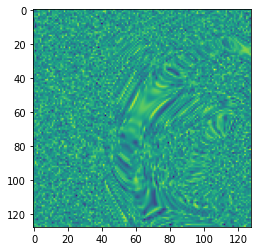

In [31]:
plt.imshow(best_seen_ronchigram)

In [ ]:
best_par_rep = np.load('Initial_optimization_50iter_50reps_parameters.npy')

In [ ]:
# Case to start with previous saved results
best_ronchigram_rep_refine = np.load('Refine_optimization_std_50iter_50reps_ronchigrams.npy')
best_seen_rep_refine = np.load('Refine_optimization_std_50iter_50reps_value.npy')
best_par_rep_refine = np.load('Refine_optimization_std_50iter_50reps_parameters.npy')

best_par_rep_refine = [best_par_rep_refine[i] for i in range(len(best_par_rep_refine))]
best_seen_rep_refine = [best_seen_rep_refine[i] for i in range(len(best_seen_rep_refine))]
best_ronchigram_rep_refine = [best_ronchigram_rep_refine[i] for i in range(len(best_ronchigram_rep_refine))]

In [18]:
# refine with aperture applied
best_par_rep_refine = []
best_seen_rep_refine = []
best_ronchigram_rep_refine = []

for irep in range(len(best_par_rep_refine), len(best_par_rep)):
    
    print('Now working on '+ str(irep) + ' ' + str(best_par_rep[irep]))
    
    # randomly generate 9 training data points, plus the one with best seen values
    train_X, train_Y = generate_initial_data(n = 9, model = model_finetune, aperture = 30)
    
    # add in the best seen point from previous optimization
    new_x = best_par_rep[irep]
    result = get_GPT_output(new_x, model_finetune, 30)
    new_x = torch.tensor([new_x])
    new_y = torch.tensor(result[1]).unsqueeze(-1).unsqueeze(-1)
    new_y = new_y + NOISE_SE * torch.randn_like(new_y) if NOISE_SE else new_y
    train_X = torch.cat([train_X, new_x])
    train_Y = torch.cat([train_Y, new_y])
    
    # build GP model from the ten training points
    if option_standardize:
        gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
    else:
        gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    bounds = torch.stack([torch.zeros(10, device = device), torch.ones(10, device = device)])
    best_observed_value = []
    
    for iteration in range(niter):

        fit_gpytorch_model(mll)

        UCB = UpperConfidenceBound(gp, beta = 2)    
        candidate, acq_value = optimize_acqf(
            UCB, bounds=bounds, q = 1, num_restarts=5, raw_samples=20,
        )
        new_x = candidate.detach()
#         print(new_x)
        
        result = get_GPT_output(np.array(new_x[0]), model_finetune, 30)
        new_y = torch.tensor(result[1]).unsqueeze(-1).unsqueeze(-1)
        new_y = new_y + NOISE_SE * torch.randn_like(new_y)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
        if not best_observed_value:
            best_par = np.array(new_x[0])
            best_value = np.array(new_y[0][0])
            best_seen_ronchigram = result[0]
        elif result[1] > best_value:
            best_par = np.array(new_x[0])
            best_value = result[1]
            best_seen_ronchigram = result[0]
        best_observed_value.append(best_value)

        # update GP model using dataset with new datapoint
        if option_standardize:
            gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
        else:
            gp = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

    
    print(irep, best_value)
        
    best_seen_rep_refine.append(np.array(best_observed_value))
    best_par_rep_refine.append(best_par)
    best_ronchigram_rep_refine.append(best_seen_ronchigram)
    
# np.save('Refine_optimization_std_50iter_50reps_value.npy', np.array(best_seen_rep_refine))
# np.save('Refine_optimization_std_50iter_50reps_ronchigrams.npy', np.array(best_ronchigram_rep_refine))
# np.save('Refine_optimization_std_50iter_50reps_parameters.npy', np.array(best_par_rep_refine))

Now working on 0 [0.20140082 0.9061937  0.95404756 0.38620883 0.78677887 0.5233724
 0.66716385 0.77530354 0.688933   0.74302626]


/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 0.8755072355270386


In [ ]:
plt.imshow(best_seen_ronchigram)
print(best_seen_ref_refine[-1])

In [ ]:
temp = np.load('Refine_optimization_50iter_50reps_value.npy', allow_pickle = True)

In [ ]:
np.save('Refine_optimization_50iter_50reps_value.npy', np.array(best_seen_rep_refine))
np.save('Refine_optimization_50iter_50reps_ronchigrams.npy', np.array(best_ronchigram_rep_refine))
np.save('Refine_optimization_50iter_50reps_parameters.npy', np.array(best_par_rep_refine))

In [ ]:
gp.likelihood.noise

In [ ]:
best_ronchigram_rep_refine = np.load('Refine_optimization_50iter_50reps_ronchigrams.npy')
best_seen_rep_refine = np.load('Refine_optimization_50iter_50reps_value.npy')
best_par_rep_refine = np.load('Refine_optimization_50iter_50reps_parameters.npy')

In [ ]:
idx = 4
plt.imshow(best_ronchigram_rep_refine[idx])
print(best_seen_rep_refine[idx][-1])

## Plot results

In [ ]:
temp = np.load('Refine_optimization_50iter_50reps_value.npy')
len(temp)

In [ ]:
result = np.load(result_path + 'RandomStartx30_50iter_initialrun_emit+defocus_prmean=0_rltBoundary_2-None.npy')
result.shape

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = [14, 5])
result_path = '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/'

result = np.load('Initial_optimization_50iter_50reps_value.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax[0].plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, label = 'Initial Optimization')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax[0].plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C0', alpha = 0.3)
ax[0].legend(loc='upper left', ncol=1, fontsize = 16)
ax[0].set_xlabel('Iterations',fontsize = 16)
ax[0].set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

result = np.load('Refine_optimization_50iter_50reps_value.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax[1].plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, c = 'C1', label = 'Refine Optimization')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax[1].plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C1', alpha = 0.3)
ax[1].legend(loc='upper left', ncol=1, fontsize = 16)
ax[1].set_xlabel('Iterations',fontsize = 16)
ax[1].set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

In [ ]:
fig, ax = plt.subplots( figsize = [6, 6])
result_path = '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/'

result = np.load('Initial_optimization_50iter_50reps_value.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax.plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, label = 'BoTorch')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C0', alpha = 0.3)
ax.legend(loc='upper left', ncol=1, fontsize = 16)
ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

result = np.load(result_path + 'RandomStartx30_50iter_initialrun_emit+defocus_prmean=0_rltBoundary_2-None.npy')
result = result[:,:50,0]
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax.plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, label = 'SLAC GP')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C1', alpha = 0.3)
ax.legend(loc='upper left', ncol=1, fontsize = 16)
ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

result = np.load(result_path + 'Simplex_Y-obs-fullGPT_30rep.npy', allow_pickle = True)
result = [np.array(entry)[0:50,0] for entry in result]
result = np.array(result)
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax.plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, c = 'C2', label = 'Simplex')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C2', alpha = 0.3)
ax.legend(loc='upper left', ncol=1, fontsize = 16)
ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.set_yscale('log')

In [ ]:
result = np.load(result_path + 'Simplex_Y-obs-fullGPT_30rep.npy', allow_pickle = True)
result = [np.array(entry)[0:50,0] for entry in result]
result = np.array(result)

In [ ]:
np.array(result).shape